## ATAC + MULTIOME (gonadal somatic september 2021)

### Dimensionality reduction with cisTopic for single samples from cellatac

In [1]:
import numpy as np
import scanpy as sc 
import pandas as pd
import anndata
sc.settings.set_figure_params(dpi=80)

**r2py setup**

In [2]:
import rpy2.rinterface_lib.callbacks
import logging

In [3]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

In [4]:
import anndata2ri
anndata2ri.activate()

In [5]:
%load_ext rpy2.ipython

In [6]:
%%R
## Install dependencies
#devtools::install_github("aertslab/RcisTarget")
#devtools::install_github("aertslab/AUCell")
        
#devtools::install_github("aertslab/cisTopic")
library(cisTopic)
library(Matrix)
library(GenomicRanges)
library(ensembldb)
library(EnsDb.Hsapiens.v86)
library(tidyr)
library(Signac)
library(cicero)

library(Matrix)
library(reticulate)
#if (!requireNamespace("remotes", quietly = TRUE)) {
#  install.packages("remotes")
#}
#remotes::install_github("mojaveazure/seurat-disk")

library(SeuratDisk)
library(Seurat)
library(GenomeInfoDb)
library(BSgenome.Hsapiens.UCSC.hg38)
library(ensembldb)
library(JASPAR2018)
library(TFBSTools)
library(patchwork)
library(universalmotif)
library(MotifDb)
library(TFBSTools)
library(patchwork)
library(chromVAR)
library(motifmatchr)

In [7]:
%%R 

writeLines(capture.output(sessionInfo()), "./sessionInfo.txt")

**Load data**

In [8]:
# Define variables
outdir = "/nfs/team292/vl6/my_MULTIOME_dir/supporting_july2021/"
experiment_prefix = 'supporting_'

In [9]:
adata = sc.read_h5ad(outdir + experiment_prefix + '_ATAC_raw.h5ad')

In [10]:
adata

AnnData object with n_obs × n_vars = 77780 × 159132
    obs: 'cellatac_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'multiome_Somatic'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'binary_raw'

**Setup of cisTopic**

In [11]:
# Remove empty rows
bool_matrix = adata.X.sum(0) > 0
bool_vector = np.squeeze(np.asarray(bool_matrix))
adata = adata[:, bool_vector]

/opt/conda/envs/atac_env/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [12]:
adata

View of AnnData object with n_obs × n_vars = 77780 × 159132
    obs: 'cellatac_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'multiome_Somatic'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'binary_raw'

**Assess if there are cells with very low number of counts**

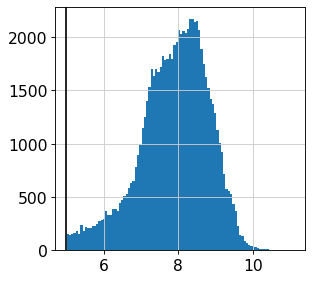

In [14]:
import matplotlib.pyplot as plt
plt.hist(adata.obs['log1p_total_counts'], bins=100);
plt.axvline(x=5, color="black")

**Convert anndata to SingleCellExperiment**

In [14]:
%%R -i adata -i outdir -i experiment_prefix
adata
#saveRDS(adata, paste0(outdir, experiment_prefix, "_SCE.RDS"))

class: SingleCellExperiment 
dim: 159132 77780 
metadata(0):
assays(2): X binary_raw
rownames(159132): chr1:816748-817444 chr1:825667-826059 ...
  chrY:20559718-20560765 chrY:22727882-22729063
rowData names(15): peak_width exon ... total_counts log1p_total_counts
colnames(77780): 01-AAACAGCCACTAGCGT-1 01-AAACCGGCAACCCTCC-1 ...
  29-TTTGTGTGTGCTGAAG-1 29-TTTGTGTGTTAACCGT-1
colData names(10): cellatac_clusters n_genes_by_counts ...
  pct_counts_in_top_500_genes multiome_Somatic
reducedDimNames(0):
altExpNames(0):


**Train cisTopic model**

In [16]:
%%R -i outdir -i experiment_prefix

# Initialize cisTopic object 
cisTopicObject <- createcisTopicObject(
    assay(adata, "X"),
    project.name='ATAC_cisTopic')

cisTopicObject
saveRDS(cisTopicObject, paste0(outdir, experiment_prefix, "_initialized_cisTopic.RDS"))

Run cisTopic in the farm 

In [17]:
#%%R -i outdir -i experiment_prefix

#topics_vec <- c(20:40)
#cisTopicObject <- runWarpLDAModels(cisTopicObject, topic = topics_vec, 
#                                   seed = 1712, 
#                                   nCores = 21, 
#                                   iterations = 500
#                                  )

#saveRDS(cisTopicObject, paste0(outdir, experiment_prefix, "_ATAC.trainedCistopic.RDS"))

In [13]:
%%R -i outdir -i experiment_prefix
cisTopicObject <- readRDS(paste0(outdir, experiment_prefix, "_ATAC.trainedCistopic.RDS"))

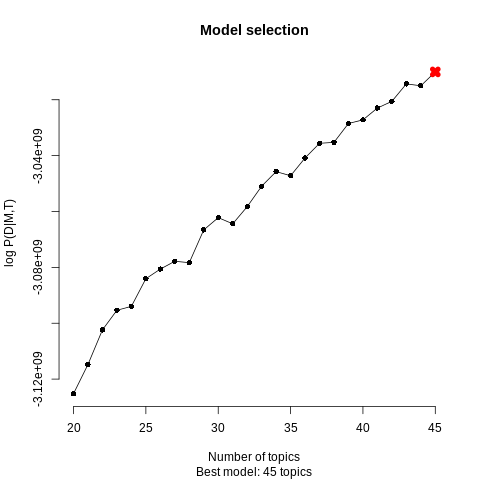

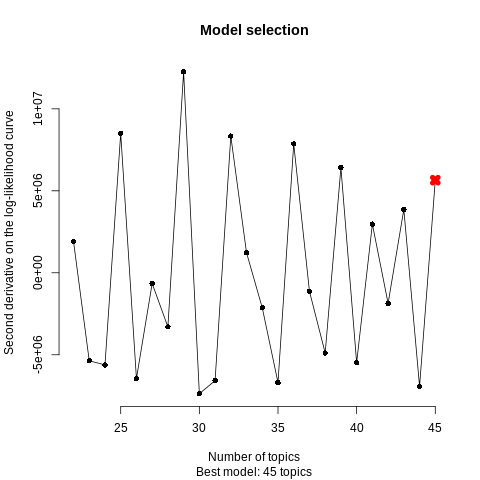

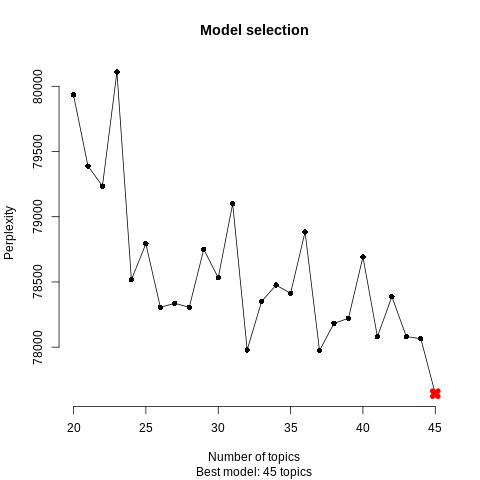

In [14]:
%%R

cistopic_model <- selectModel(cisTopicObject, type = "maximum")

In [17]:
%%R -o topicXcell
## Save topic matrix ##
topicXcell <- modelMatSelection(cistopic_model, 'cell', 'Probability')

dim(topicXcell)

[1]    45 77780


In [18]:
topicXcell

array([[6.66666667e-03, 2.98913043e-03, 4.61538462e-02, ...,
        1.08200015e-03, 9.38361313e-03, 1.09975217e-02],
       [3.61904762e-02, 4.34782609e-03, 1.37362637e-02, ...,
        2.61998609e-02, 7.64219494e-04, 5.28190830e-03],
       [9.52380952e-03, 2.98913043e-03, 4.39560440e-03, ...,
        3.86428627e-05, 3.38261087e-04, 2.16852540e-04],
       ...,
       [1.38095238e-02, 2.14673913e-02, 1.48351648e-02, ...,
        2.90238813e-01, 1.37810073e-03, 6.66047088e-03],
       [1.23809524e-02, 1.27717391e-02, 4.39560440e-03, ...,
        1.00471443e-04, 1.12753696e-04, 1.08426270e-04],
       [5.23809524e-03, 1.14130435e-02, 1.15384615e-02, ...,
        5.35821934e-02, 1.75394638e-03, 5.51425031e-03]])

In [22]:
adata.obsm['X_cistopic_45'] = topicXcell.T

**Visualize dimensionality reduction results**

In [23]:
sc.pp.neighbors(adata, n_neighbors=15, use_rep="X_cistopic_45")

In [24]:
sc.tl.umap(adata, min_dist = 0.4, spread = 1.2)

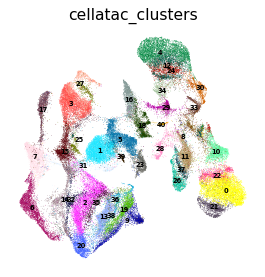

In [25]:
adata.obs["cellatac_clusters"] = adata.obs["cellatac_clusters"].astype("category")
sc.pl.umap(adata, color = "cellatac_clusters", frameon = False, size = 1, legend_loc = 'on data', legend_fontsize = 6)


In [26]:
colors = ['royalblue', 'orange', 'green', 'red', 'orchid', 'pink','brown',  'yellowgreen', 
                'deepskyblue',  'lightgrey',]

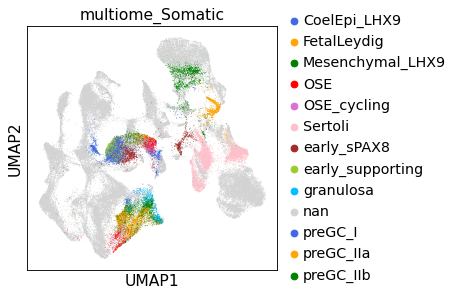

In [27]:
sc.pl.umap(adata, color = ['multiome_Somatic'], palette = colors)

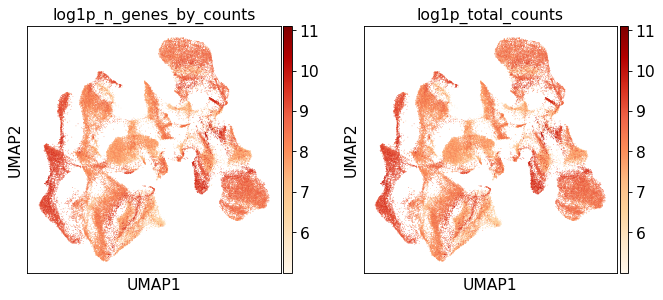

In [28]:
sc.pl.umap(adata, color = ['log1p_n_genes_by_counts', 'log1p_total_counts'], ncols = 2, color_map = "OrRd")

**Add metadata for females**

In [29]:
# Code from cell barcodes 
adata.obs['code'] = [name[0:2] for name in adata.obs_names]
adata.obs['code'].value_counts(dropna = False)

16    8761
06    7769
22    5332
19    4522
18    4413
21    4354
13    4072
20    3825
27    3687
26    3548
23    3515
15    2866
11    2641
17    2421
14    2220
05    1733
28    1631
01    1195
25    1164
02    1161
10    1140
24    1125
08    1115
04     941
29     900
07     637
03     555
09     375
12     162
Name: code, dtype: int64

In [30]:
# Sample from code 
sample_code = {'01' : 'FCA_GND10288176', '02' : 'FCA_GND10288177', '03' : 'FCA_GND10288178', '04' : 'FCA_GND10288179', 
               '05' : 'FCA_GND10288180', '06' : 'FCA_GND8046539', '07' : 'FCA_GND8768481', '08' : 'FCA_GND8768482',
               '09' : 'FCA_GND8768483', '10' : 'FCA_GND8768484', '11' : 'FCA_GND8768485', '12' : 'FCA_GND8768487',
               '13' : 'FCA_GND8795927', '14' : 'FCA_GND8795928', '15' : 'FCA_GND9332157', '16' : 'HCA_F_GON10535399',
               '17' : 'HCA_F_GON10687818', '18' : 'HCA_F_GON10687819', '19' : 'HCA_F_GON10687820', '20' : 'HD_F_GON9479872',
               '21' : 'HD_F_GON9479873', '22' : 'HD_F_GON9479874', '23' : 'HD_F_GON9479875', '24' : 'HD_F_GON9525611',
               '25' : 'HD_F_GON9525612', '26' : 'HD_F_GON9883955', '27' : 'HD_F_GON9883958', '28' : 'HD_F_GON9883959',
               '29' : 'HD_F_GON9883960'}
adata.obs['sample'] = adata.obs['code'].map(sample_code) 
adata.obs['sample'].value_counts(dropna = False)

HCA_F_GON10535399    8761
FCA_GND8046539       7769
HD_F_GON9479874      5332
HCA_F_GON10687820    4522
HCA_F_GON10687819    4413
HD_F_GON9479873      4354
FCA_GND8795927       4072
HD_F_GON9479872      3825
HD_F_GON9883958      3687
HD_F_GON9883955      3548
HD_F_GON9479875      3515
FCA_GND9332157       2866
FCA_GND8768485       2641
HCA_F_GON10687818    2421
FCA_GND8795928       2220
FCA_GND10288180      1733
HD_F_GON9883959      1631
FCA_GND10288176      1195
HD_F_GON9525612      1164
FCA_GND10288177      1161
FCA_GND8768484       1140
HD_F_GON9525611      1125
FCA_GND8768482       1115
FCA_GND10288179       941
HD_F_GON9883960       900
FCA_GND8768481        637
FCA_GND10288178       555
FCA_GND8768483        375
FCA_GND8768487        162
Name: sample, dtype: int64

... storing 'code' as categorical
... storing 'sample' as categorical


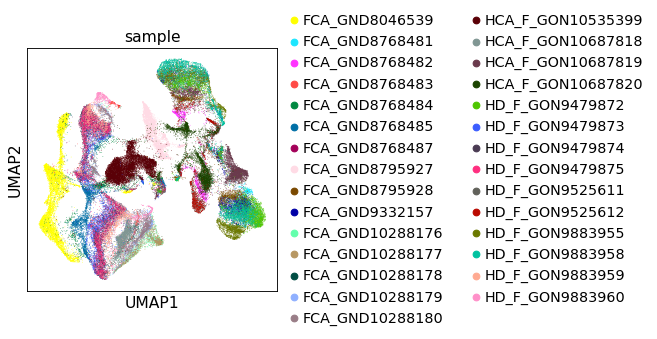

In [31]:
sc.pl.umap(adata, color = 'sample')

In [32]:
sex_dictionary = {'HCA_F_GON10535399' : 'female', 'HCA_F_GON10687818' : 'female', 'FCA_GND8046539' : 'female', 
                    'FCA_GND8768483' : 'female', 'FCA_GND8768484' : 'female', 'FCA_GND8768485' : 'female', 
                     'HD_F_GON9479873' : 'female', 'HD_F_GON9479874' : 'female', 'HD_F_GON9479875' : 'female', 
                'HD_F_GON9883959' : 'female', 'HD_F_GON9883960' : 'female', 
                   'FCA_GND10288176' : 'female', 'FCA_GND10288177' : 'female', 'FCA_GND10288178' : 'female', 
                    'FCA_GND10288179' : 'female', 'FCA_GND10288180' : 'female', 
                 'HCA_F_GON10687819' : 'male', 'HCA_F_GON10687820' : 'male', 'FCA_GND8768481' : 'male', 
                   'FCA_GND8768482' : 'male', 'FCA_GND8768487' : 'male', 'FCA_GND8795927' : 'male',
                     'FCA_GND8795928' : 'male', 'HD_F_GON9479872' : 'male', 'HD_F_GON9525611' : 'male', 
                     'HD_F_GON9525612' : 'male', 'FCA_GND9332157' : 'male', 'HD_F_GON9883958' : 'male',
                     'HD_F_GON9883955' : 'male', 'FCA_GND8768483' : 'female', 'FCA_GND8768487' : 'male', 
                 'HD_F_GON9479872' : 'male'}
adata.obs['sex'] = adata.obs['sample'].map(sex_dictionary)
adata.obs['sex'].value_counts(dropna = False)

female    44424
male      33356
Name: sex, dtype: int64

In [33]:
stage_dictionary = {'FCA_GND8046539' : '8 PCW', 'FCA_GND8768484' : '8 PCW', 'FCA_GND8768483' : '14 PCW', 
                    'HD_F_GON9479874' : '14 PCW', 'HD_F_GON9479873' : '13 PCW',
                  'HD_F_GON9479875' : '14 PCW', 
                    'FCA_GND8768485' : '9 PCW', 
                   'HD_F_GON9883959' : '18 PCW', 'HD_F_GON9883960' : '21 PCW', 
                   'FCA_GND10288176' : '21 PCW', 
                 'FCA_GND10288177' : '21 PCW', 'FCA_GND10288178' : '14 PCW', 'FCA_GND10288179' : '20 PCW', 
                 'FCA_GND10288180' : '20 PCW', 'HCA_F_GON10535399' : '8.6 PCW', 'HCA_F_GON10687818' : '13 PCW',
                    'HCA_F_GON10687819' : '19 PCW', 'HCA_F_GON10687820' : '8.8 PCW', 'FCA_GND8768481' : '19 PCW', 
                   'FCA_GND8768482' : '9 PCW', 'FCA_GND8768487' : '12 PCW', 'FCA_GND8795927' : '7 PCW',
                     'FCA_GND8795928' : '12 PCW', 'HD_F_GON9479872' : '15 PCW', 'HD_F_GON9525611' : '12 PCW', 
                     'HD_F_GON9525612' : '12 PCW', 'FCA_GND9332157' : '17 PCW', 'HD_F_GON9883958' : '21 PCW',
                     'HD_F_GON9883955' : '17 PCW',  'FCA_GND8768483' : '14 PCW', 'FCA_GND8768487' : '12 PCW', 
                 'HD_F_GON9479872' : '15 PCW' }
adata.obs['stage'] = adata.obs['sample'].map(stage_dictionary)
adata.obs['stage'].value_counts(dropna = False)

14 PCW     9777
8 PCW      8909
8.6 PCW    8761
21 PCW     6943
13 PCW     6775
17 PCW     6414
19 PCW     5050
12 PCW     4671
8.8 PCW    4522
7 PCW      4072
15 PCW     3825
9 PCW      3756
20 PCW     2674
18 PCW     1631
Name: stage, dtype: int64

In [34]:
individual_dictionary = {'FCA_GND8046539' : 'F81', 'FCA_GND8768484' : 'Hrv12', 'FCA_GND8768483' : 'Hrv11', 
                    'HD_F_GON9479874' : 'Hrv50', 'HD_F_GON9479871' : 'Hrv39', 'HD_F_GON9479873' : 'Hrv49',
                  'HD_F_GON9479875' : 'Hrv50', 
                    'FCA_GND8768485' : 'Hrv13', 
                        'HD_F_GON9883959' : 'Hrv59', 'HD_F_GON9883960' : 'Hrv58', 
                         'FCA_GND10288176' : 'Hrv58', 
                 'FCA_GND10288177' : 'Hrv58', 'FCA_GND10288178' : 'Hrv39', 'FCA_GND10288179' : 'Hrv65', 
                 'FCA_GND10288180' : 'Hrv65', 'HCA_F_GON10535399' : 'Hrv92', 'HCA_F_GON10687818' : 'Hrv91', 
                         'HCA_F_GON10687819' : 'Hrv3', 'HCA_F_GON10687820' : 'Hrv41', 'FCA_GND8768481' : 'Hrv3', 
                   'FCA_GND8768482' : 'Hrv10', 'FCA_GND8768487' : 'Hrv15', 'FCA_GND8795927' : 'Hrv17',
                     'FCA_GND8795928' : 'Hrv18', 'HD_F_GON9479872' : 'Hrv40', 'HD_F_GON9525611' : 'Hrv15', 
                     'HD_F_GON9525612' : 'Hrv15', 'FCA_GND9332157' : 'Hrv21', 'HD_F_GON9883958' : 'Hrv54',
                     'HD_F_GON9883955' : 'Hrv55',  'FCA_GND8768483' : 'Hrv11', 'FCA_GND8768487' : 'Hrv15', 
                 'HD_F_GON9479872' : 'Hrv40'}
adata.obs['individual'] = adata.obs['sample'].map(individual_dictionary)
adata.obs['individual'].value_counts(dropna = False)

Hrv50    8847
Hrv92    8761
F81      7769
Hrv3     5050
Hrv41    4522
Hrv49    4354
Hrv17    4072
Hrv40    3825
Hrv54    3687
Hrv55    3548
Hrv58    3256
Hrv21    2866
Hrv65    2674
Hrv13    2641
Hrv15    2451
Hrv91    2421
Hrv18    2220
Hrv59    1631
Hrv12    1140
Hrv10    1115
Hrv39     555
Hrv11     375
Name: individual, dtype: int64

#### Plot metadata information

... storing 'sex' as categorical
... storing 'stage' as categorical
... storing 'individual' as categorical


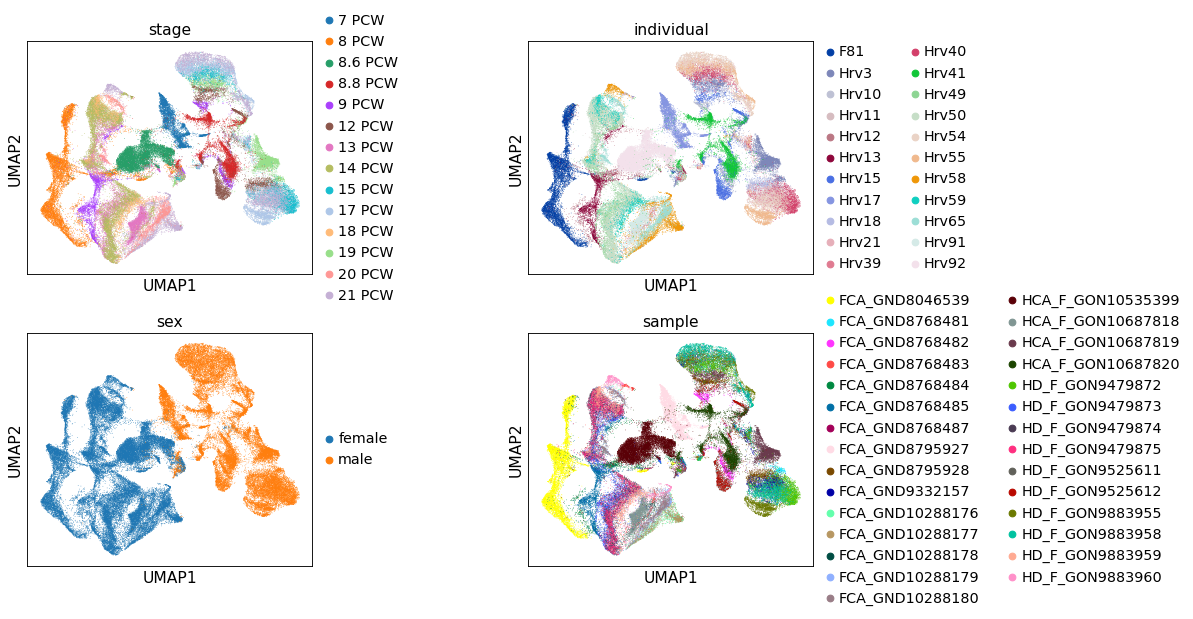

In [35]:
sc.pl.umap(adata, color = ['stage', 'individual','sex', 'sample'], ncols = 2, wspace = 0.6)

#### De-noising the peak x cell matrix with cisTopic

The learnt LDA model from cisTopic can be used to generate a de-noised accessibility matrix. From the paper:

cisTopic calculates the predictive distribution, which describes the probability of each region in each cell, by multiplying the topic–cell and the region–topic distributions:
𝑃(𝑟𝑖|𝑐𝑗)=∑𝑘=1𝐾𝑃(𝑟𝑖|𝑇𝑘)𝑃(𝑇𝑘|𝑐𝑗)
 
where

 * 𝑃(𝑟𝑖|𝑐𝑗)  is the probability of region i in cell j,
 * 𝑃(𝑟𝑖|𝑇𝑘)  is the probability of region i in topic k, and
 * 𝑃(𝑇𝑘|𝑐𝑗)  is the probability of topic k in cell j.

In [17]:
#%%R 

#install.packages("bigmemory")

In [15]:
%%R -o p_mat

library(bigmemory)
p_mat <- predictiveDistribution(cistopic_model, big.matrix=FALSE)

In [16]:
%%R
dim(p_mat)

[1] 159132  77780


In [17]:
p_mat

array([[3.52214658e-06, 2.95919209e-06, 4.91881296e-06, ...,
        8.59669625e-07, 2.39033123e-06, 2.43814199e-06],
       [3.49608580e-06, 3.53619124e-06, 3.18488165e-06, ...,
        6.38887960e-07, 3.28345613e-06, 3.21203976e-06],
       [3.32180965e-05, 2.48582880e-05, 2.77690108e-05, ...,
        2.63434007e-05, 3.84608108e-05, 3.62499888e-05],
       ...,
       [1.02625400e-06, 2.42014194e-06, 8.90446276e-07, ...,
        3.08556362e-07, 5.04857532e-07, 2.99651267e-07],
       [1.79624136e-06, 8.80287718e-07, 1.71429912e-06, ...,
        2.66632245e-07, 2.49351621e-07, 3.07101236e-07],
       [5.27142554e-06, 1.87942478e-06, 4.37125069e-06, ...,
        8.71856057e-07, 1.30422112e-06, 1.97604247e-06]])

#### Important: 

cistopic_p is a numpy array (cannot convert to sparse matrix because it crashes), and it is too large to save --> will save it in a separate object

In [18]:
adata.layers["cistopic_p"] = p_mat.T

#### Calculate de-noised gene scores

The de-noised accessibility signal can be used to calculate a gene-level accessibility scores (first implemented in Bravo Gonzales-Blas et al. 2020). This is very useful to check out accessibility of marker genes for example. From the paper:

we first multiply the region‐topic and topic‐cell distributions to obtain a region‐cell distribution, which indicates the probability of accessibility of each region in each cell. Then, for each gene, we aggregate the probabilities of the surrounding regions (in this case, 5 kb around the TSS plus introns), resulting in a gene activity score

At the moment there is no specific function in cisTopic to do this, but here is a simple implementation using functionality in GenomicRanges and Signac. Here I use peaks within a 5kb window of a gene (d parameter)

In [41]:
%%R 
library(GenomicRanges)
library(ensembldb)
library(EnsDb.Hsapiens.v86)
library(tidyr)
# library(Signac)

In [42]:
%%R

StringToGRanges <- function(regions, sep = c("-", "-"), ...) {
  ranges.df <- data.frame(ranges = regions)
  ranges.df <- separate(
    data = ranges.df,
    col = "ranges",
    sep = paste0(sep[[1]], "|", sep[[2]]),
    into = c("chr", "start", "end")
  )
  granges <- makeGRangesFromDataFrame(df = ranges.df, ...)
  return(granges)
}

GRangesToString <- function(grange, sep = c("-", "-")) {
  regions <- paste0(
    as.character(x = seqnames(x = grange)),
    sep[[1]],
    start(x = grange),
    sep[[2]],
    end(x = grange)
  )
  return(regions)
}

# Extend genomicRanges
# 
extend <- function(x, upstream=0, downstream=0)     
{
    if (any(strand(x) == "*"))
        warning("'*' ranges were treated as '+'")
    on_plus <- strand(x) == "+" | strand(x) == "*"
    new_start <- start(x) - ifelse(on_plus, upstream, downstream)
    new_end <- end(x) + ifelse(on_plus, downstream, upstream)
    ranges(x) <- IRanges(new_start, new_end)
    trim(x)
}


# Find peaks close to features of interest
#
# @param peaks_gr GenomicRanges object containing peaks
# @param features_gr GenomicRanges object containing features (e.g. genes)
# @param d distance to include peak, in bps (default 50000)
# @param feat_anno column in `features_gr@elementMetadata` containing annotation to name features (if NULL converts Granges to string)
#
# @return Sparse adjacency matrix indicating hits
peak2feature <- function(peaks_gr, features_gr, d=50000, feat_anno=NULL){
  seqlevelsStyle(features_gr) <- seqlevelsStyle(peaks_gr)
  
  ## Find peaks overlapping the search range around the features
  ext_gr <- extend(features_gr, upstream = d, downstream = d)
  ovs <- findOverlaps(peaks_gr, ext_gr)
  
  ## Define identifiers for peaks and features
  all_peaks <- GRangesToString(peaks_gr, sep = c(":", '-'))
  if (is.null(feat_anno)) {
    all_feats <- GRangesToString(features_gr, sep = c(":", '-'))
  } else {
    all_feats <- features_gr@elementMetadata[[feat_anno]]
  }
  
  ## Build adjacency matrix for hits
  print("Got to here")
  print(typeof(length(all_peaks)))
  print(typeof(length(all_feats)))
  adj_mat <- Matrix::Matrix(data=0, nrow = length(all_peaks), ncol=length(all_feats))
  for (i in unique(subjectHits(ovs))) {
    # if (length(adj_mat[queryHits(ovs[subjectHits(ovs)==i]),i]) > 0) {
    adj_mat[queryHits(ovs[subjectHits(ovs)==i]),i] <- 1
    # }
  }
  colnames(adj_mat) <- all_feats
  rownames(adj_mat) <- all_peaks
  
  adj_mat
  
}

In [43]:
%%R
genes_gr <- genes(EnsDb.Hsapiens.v86)
peaks_gr <- StringToGRanges(rownames(assay(adata, "X")), sep=c(":", "-"))

In [44]:
%%R -o adj_mat
## Compute peak2gene adjacency matrix
adj_mat <- peak2feature(peaks_gr, genes_gr, feat_anno = "gene_id", d=5000)

# Filter genes with at least 3 peaks in the proximity
keep.genes <- which(colSums(adj_mat) > 2) 
adj_mat <- t(adj_mat[,keep.genes])

[1] "Got to here"
[1] "integer"
[1] "integer"


In [45]:
%%R -o gene_var
head(rownames(adj_mat))
genes <- rownames(adj_mat)
gene_var <- genes_gr[genes,]@elementMetadata[c("gene_id","gene_name")]

### Alternative implementation of dot product between *adj_mat* and *p_mat*

In [46]:
print(np.__version__)

1.21.2


In [47]:
import math

#### adj_mat

In [48]:
rows_adj_mat = adj_mat.shape[0]
print(rows_adj_mat)
cols_adj_mat = adj_mat.shape[1]
print(cols_adj_mat)

16693
159132


In [49]:
a1 = adj_mat[0:math.ceil(rows_adj_mat/2), 0:math.ceil(cols_adj_mat/2)]
a2 = adj_mat[0:math.ceil(rows_adj_mat/2), math.ceil(cols_adj_mat/2):]
a3 = adj_mat[math.ceil(rows_adj_mat/2):, 0:math.ceil(cols_adj_mat/2)]
a4 = adj_mat[math.ceil(rows_adj_mat/2):, math.ceil(cols_adj_mat/2):]

In [50]:
print("a1 : {}\na2 : {}\na3 : {}\na4 : {}".format(a1.shape, a2.shape, a3.shape, a4.shape))

a1 : (8347, 79566)
a2 : (8347, 79566)
a3 : (8346, 79566)
a4 : (8346, 79566)


#### p_mat

In [51]:
rows_p_mat = p_mat.shape[0]
print(rows_p_mat)
cols_p_mat = p_mat.shape[1]
print(cols_p_mat)

159132
77780


In [52]:
b1 = p_mat[0:math.ceil(rows_p_mat/2), 0:math.ceil(cols_p_mat/2)]
b2 = p_mat[0:math.ceil(rows_p_mat/2), math.ceil(cols_p_mat/2):]
b3 = p_mat[math.ceil(rows_p_mat/2):, 0:math.ceil(cols_p_mat/2)]
b4 = p_mat[math.ceil(rows_p_mat/2):, math.ceil(cols_p_mat/2):]

In [53]:
print("b1 : {}\nb2 : {}\nb3 : {}\nb4 : {}".format(b1.shape, b2.shape, b3.shape, b4.shape))

b1 : (79566, 38890)
b2 : (79566, 38890)
b3 : (79566, 38890)
b4 : (79566, 38890)


#### Strassen matrix multiplication

In [54]:
c1 = np.add(a1.dot(b1), a2.dot(b3))

In [55]:
c1.shape

(8347, 38890)

In [56]:
c2 = np.add(a1.dot(b2), a2.dot(b4))

In [57]:
c2.shape

(8347, 38890)

In [58]:
c3 = np.add(a3.dot(b1), a4.dot(b3))

In [59]:
c3.shape

(8346, 38890)

In [60]:
c4 = np.add(a3.dot(b2), a4.dot(b4))

In [61]:
c4.shape

(8346, 38890)

In [62]:
c12 = np.concatenate((c1, c2), axis=1)

In [63]:
c12.shape

(8347, 77780)

In [64]:
c34 = np.concatenate((c3, c4), axis=1)

In [65]:
c34.shape

(8346, 77780)

In [66]:
gene_mat = np.concatenate((c12, c34), axis=0)

In [67]:
gene_mat.shape

(16693, 77780)

In [68]:
gene_mat

array([[4.02363288e-05, 3.13536714e-05, 3.58727054e-05, ...,
        2.78419583e-05, 4.41345982e-05, 4.19001705e-05],
       [2.59615346e-05, 1.71117971e-05, 2.59582884e-05, ...,
        1.63951260e-05, 2.95704702e-05, 2.98504494e-05],
       [2.59615346e-05, 1.71117971e-05, 2.59582884e-05, ...,
        1.63951260e-05, 2.95704702e-05, 2.98504494e-05],
       ...,
       [2.93127070e-05, 1.97265977e-05, 2.13091959e-05, ...,
        7.85585362e-06, 7.87269811e-06, 1.02068324e-05],
       [1.26097139e-05, 1.51073868e-05, 9.82426652e-06, ...,
        4.17595946e-06, 4.51260266e-06, 4.68903415e-06],
       [3.76131165e-05, 2.23436894e-05, 2.77855748e-05, ...,
        8.92432531e-06, 1.01922769e-05, 1.45816771e-05]])

In [69]:
# gene_mat = adj_mat.dot(p_mat) --> kills the kernel because both matrices need to be hold in memory 

Save another anndata object with the same .obs as the original one, but storing the gene score info.

In [70]:
%%R -i gene_mat -o predMatSumByGene

# Multiply and round predictive matrix to be able to integrate with scRNAseq data
predMatSumByGene <- round(gene_mat * 1000000)

In [71]:
gene_var = gene_var.set_index("gene_name")
gene_var.head()

gene_id
gene_name                    
RP5-857K21.4  ENSG00000230021
FAM41C        ENSG00000230368
TUBB8P11      ENSG00000234711
FAM166AP3     ENSG00000283040
RP11-54O7.16  ENSG00000272438

In [72]:
predMatSumByGene = predMatSumByGene.T
predMatSumByGene.shape

(77780, 16693)

In [73]:
gene_adata = anndata.AnnData(X=predMatSumByGene, 
                             obs=adata.obs, 
                             var=gene_var)
gene_adata

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 77780 × 16693
    obs: 'cellatac_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'multiome_Somatic', 'code', 'sample', 'sex', 'stage', 'individual'
    var: 'gene_id'

In [74]:
gene_adata.var_names_make_unique()

In [75]:
# Add cisTopic dimensionality reduction to match visualization 
gene_adata.obsm['X_cistopic_45'] = topicXcell.T

In [76]:
adata

AnnData object with n_obs × n_vars = 77780 × 159132
    obs: 'cellatac_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'multiome_Somatic', 'code', 'sample', 'sex', 'stage', 'individual'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'neighbors', 'umap', 'cellatac_clusters_colors', 'multiome_Somatic_colors', 'sample_colors', 'stage_colors', 'individual_colors', 'sex_colors'
    obsm: 'X_cistopic_45', 'X_umap'
    layers: 'binary_raw', 'cistopic_p'
    obsp: 'distances', 'connectivities'

In [77]:
del adata.layers['cistopic_p']

In [78]:
adata

AnnData object with n_obs × n_vars = 77780 × 159132
    obs: 'cellatac_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'multiome_Somatic', 'code', 'sample', 'sex', 'stage', 'individual'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'neighbors', 'umap', 'cellatac_clusters_colors', 'multiome_Somatic_colors', 'sample_colors', 'stage_colors', 'individual_colors', 'sex_colors'
    obsm: 'X_cistopic_45', 'X_umap'
    layers: 'binary_raw'
    obsp: 'distances', 'connectivities'

**Save anndata objects**

In [79]:
gene_adata.write(outdir + experiment_prefix + "_ATAC.geneScores.h5ad")

In [80]:
adata.write(outdir + experiment_prefix + "_ATAC.wCisTopic.h5ad")

**Proceed with gene_data to look at marker genes**

In [81]:
sc.pp.neighbors(gene_adata, n_neighbors=15, use_rep="X_cistopic_45")

In [82]:
sc.tl.umap(gene_adata, min_dist = 0.4, spread = 1.2)

**Plot markers per cell type from RNA-seq**

In [83]:
mesothelial = ['LRRN4', 'UPK3B', 'KLK11'] 
gonad_somatic_cells = ['NR5A1', 'AMHR2', 'MIR202HG'] 
supporting = ['WNT6', 'WIPF3']
supporting_LGR5 = ['LGR5']
supporting_PAX8 = ['PAX8']
preGranulosa_lineage = ["KITLG",  'RSPO1', 'OSR1' , 'NR4A1']
granulosa_lineage = ['FOXL2', 'IRX3', 'CYP19A1', 'RDH10']
sertoli_lineage = ['SOX9', 'INHBB', 'AMH', 'CLDN11', 'INHA', 'TFF3', 'DKK3']
mesenchymal_steroidogenic = ['CYP11A1', 'CYP17A1', 'STAR',  'MGARP', 'FDXR']
leydigFetal_lineage = ['FDX1'] # Not there
leydig_lineage = ['INSL3', 'GLI1', 'HHIP', 'PTCH2']
preTheca_lineage = ['KIT', 'LHCGR'] # Not there
mesenchymal = ['DCN', 'PDGFRA','TCF21', 'OGN', 'POSTN']
gonadal_mesenchymal = ['LHX9', 'GATA4']
ovary_stroma = ['SPRR2F', 'AKR1C1', 'DIRAS3'] # Not there
testis_border_mesenhyme = ['IGF1', 'FGL2', 'PCSK2', 'ANGPTL1']
testis_myoid= ['PTCH1', 'NGFR', 'MSC', 'NEFL']
extragonadal_mesen = ['GATA2', 'NR2F1', 'WNT4', 'RSPO3', 'MEIS1', 'FAP']
mesoneprhic_stroma = ['CRABP1', 'ALX1',  'FOXD1']
gonad_dev = ['EMX2', 'WT1']
muscoskeletal = ['MYF5','PAX7','MYF6', 'MYLPF']
epithelial = ["EPCAM"]
PGCs= ['POU5F1', 'NANOG', 'NANOS3']
GCs = ['DAZL', 'DDX4']
immunePGCs= ['PTPRC']
endothelial = ['PECAM1', 'VWF', 'CDH5']
erythroid = ["GYPC", "HBA1"]
neural = ['ASCL1', 'ELAVL4']
PV = ["PDGFRB", 'ACTA2']
cycling = ['CDK1', 'MKI67'] # Not there
quiescent = ['CDKN1B']
male = ['SRY', 'RPS4Y1','DDX3Y'] # Not there

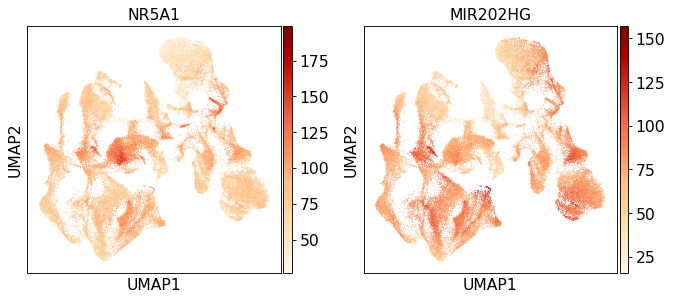

In [84]:
# Gonadal somatic
sc.pl.umap(gene_adata, color = ['NR5A1',  'MIR202HG'] , ncols = 3, color_map = 'OrRd')

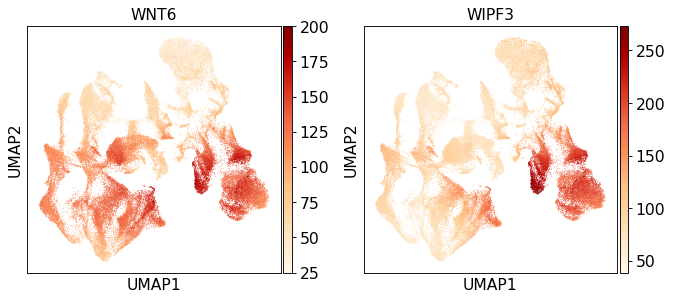

In [85]:
sc.pl.umap(gene_adata, color = supporting, ncols = 3, color_map = 'OrRd')

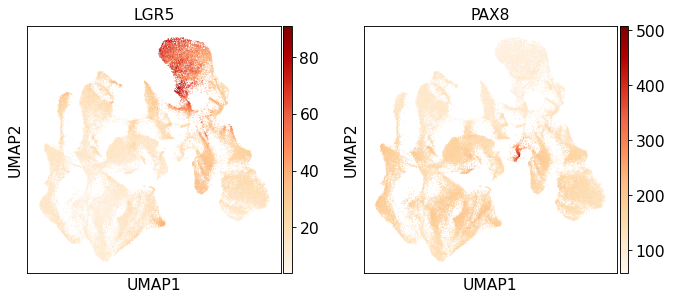

In [86]:
sc.pl.umap(gene_adata, color = ['LGR5', 'PAX8'], ncols = 3, color_map = 'OrRd')

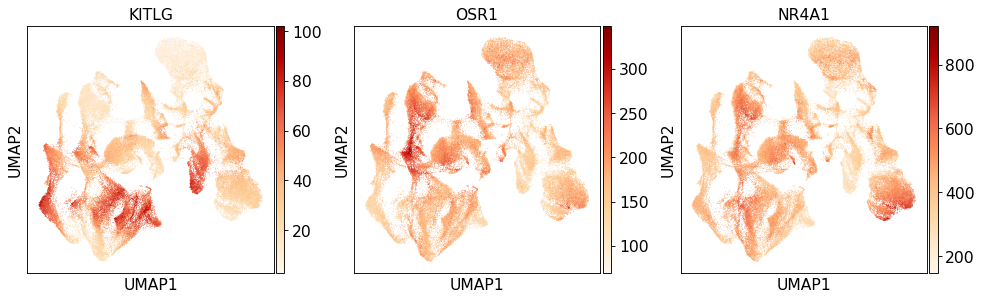

In [87]:
# Pregranulosa
sc.pl.umap(gene_adata, color = ["KITLG", 'OSR1' , 'NR4A1'], ncols = 3, color_map = 'OrRd')

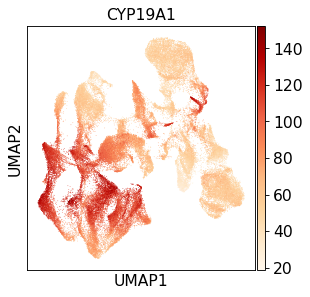

In [88]:
# Granulosa 
sc.pl.umap(gene_adata, color = ['CYP19A1'], ncols = 2, color_map = 'OrRd')

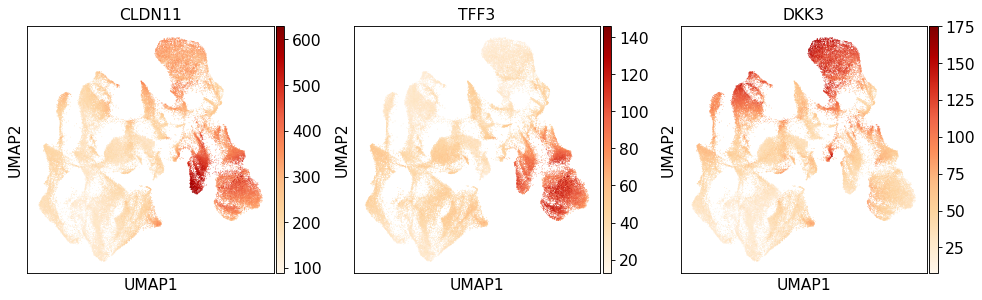

In [89]:
# Sertoli lineage
sc.pl.umap(gene_adata, color = [ 'CLDN11', 'TFF3', 'DKK3'], ncols = 3, color_map = 'OrRd')

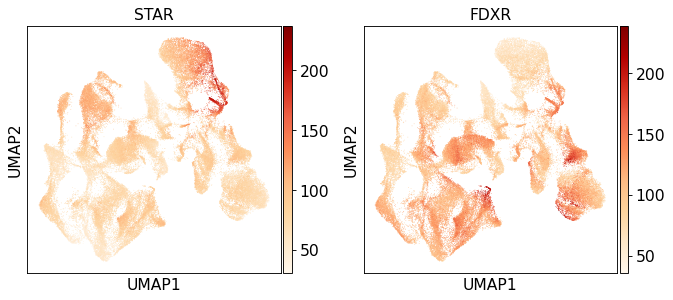

In [90]:
# Steroidogenic mesenchymal 
sc.pl.umap(gene_adata, color = ['STAR',  'FDXR'], ncols = 3, color_map = 'OrRd')

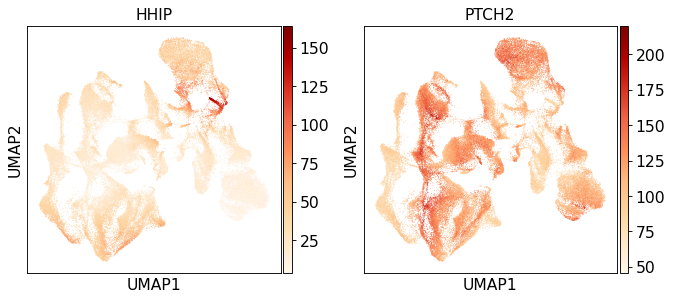

In [91]:
# Leydig lineage
sc.pl.umap(gene_adata, color = ['HHIP', 'PTCH2'], ncols = 3, color_map = 'OrRd')

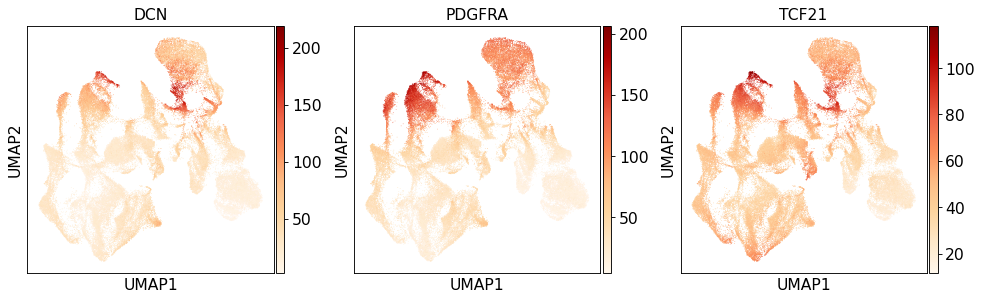

In [92]:
# Mesenchymal 
sc.pl.umap(gene_adata, color = ['DCN', 'PDGFRA','TCF21'], ncols = 3, color_map = 'OrRd')

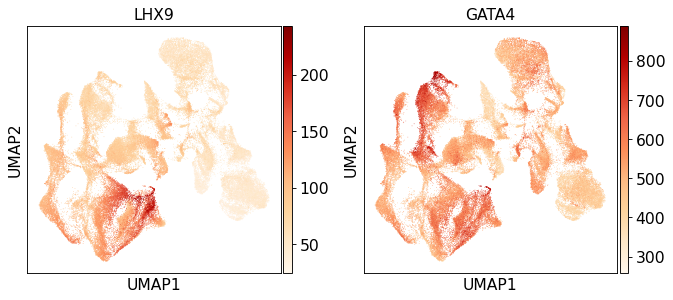

In [93]:
# Gonadal mesenchymal 
sc.pl.umap(gene_adata, color = ['LHX9', 'GATA4'], ncols = 3, color_map = 'OrRd')

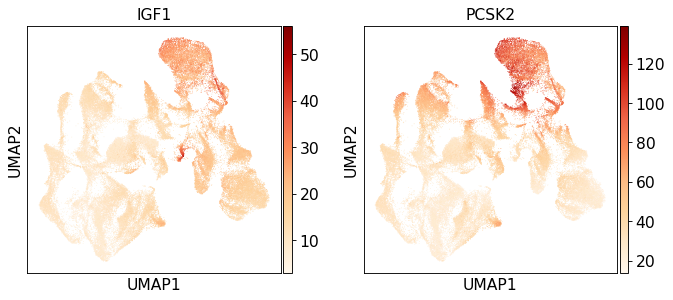

In [94]:
# Testis border mesenchyme
sc.pl.umap(gene_adata, color = ['IGF1', 'PCSK2'], ncols = 3, color_map = 'OrRd')

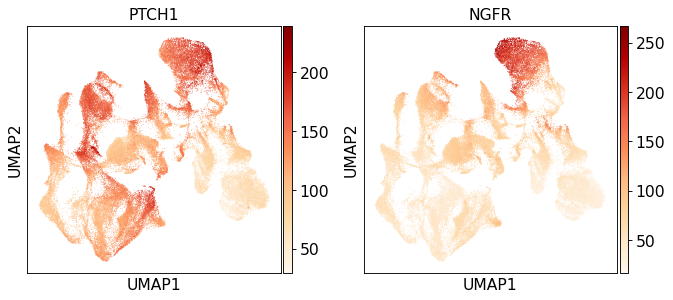

In [95]:
# Testis myoid
sc.pl.umap(gene_adata, color = ['PTCH1', 'NGFR'], ncols = 3, color_map = 'OrRd')

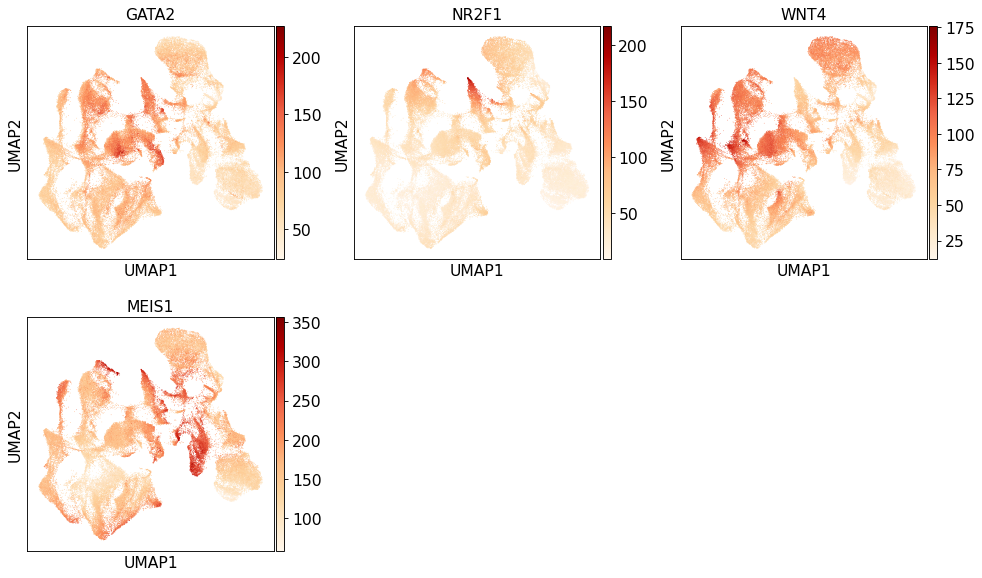

In [96]:
# Extragonal mesenchymal 
sc.pl.umap(gene_adata, color = ['GATA2', 'NR2F1', 'WNT4',  'MEIS1'], ncols = 3, color_map = 'OrRd')

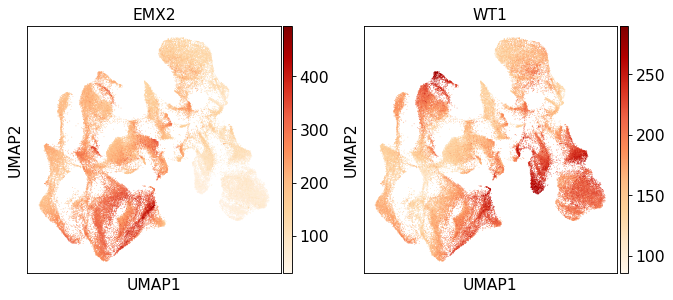

In [97]:
# Gonad dev
sc.pl.umap(gene_adata, color = ['EMX2', 'WT1'], ncols = 3, color_map = 'OrRd')

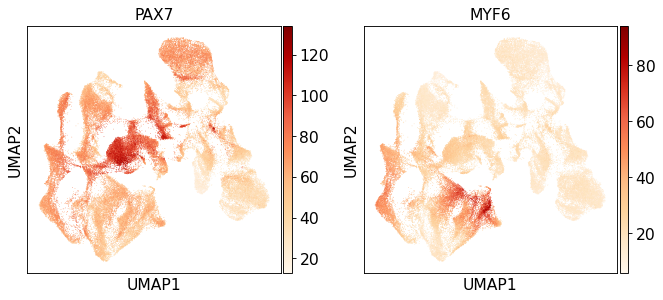

In [98]:
# Muscoskeletal 
sc.pl.umap(gene_adata, color = ['PAX7','MYF6'], ncols = 3, color_map = 'OrRd')

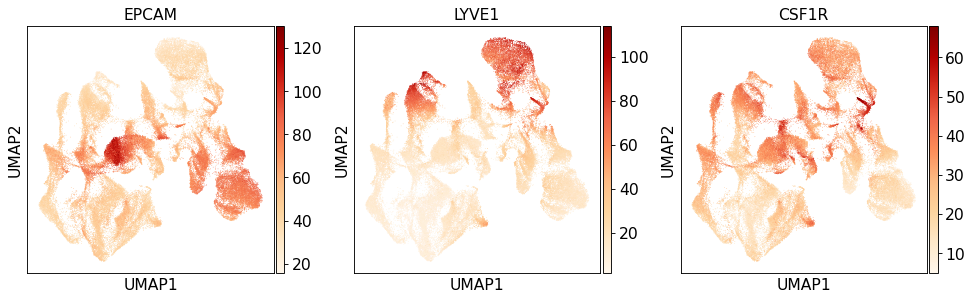

In [99]:
# Epithelial and immune
sc.pl.umap(gene_adata, color = [ 'EPCAM',  'LYVE1', 'CSF1R' 
                                                           ], ncols = 3, color_map = 'OrRd')

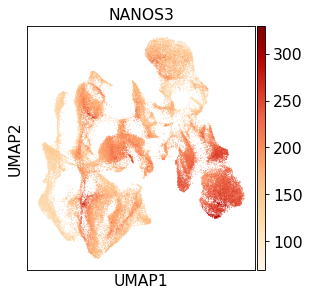

In [100]:
# PGC
sc.pl.umap(gene_adata, color = [ 'NANOS3'], ncols = 3, color_map = 'OrRd')

In [101]:
# Germ cells
#sc.pl.umap(gene_adata, color = ['DAZL',  'STRA8', 'ZP3'], ncols = 3, color_map = 'OrRd')

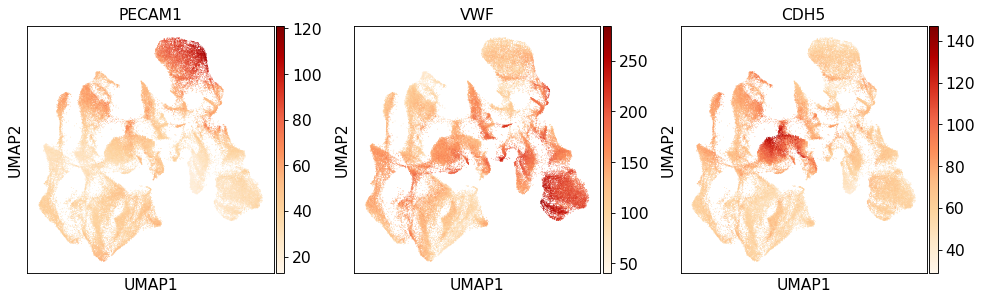

In [102]:
# Endothelial
sc.pl.umap(gene_adata, color = ['PECAM1', 'VWF', 'CDH5'], ncols = 3, color_map = 'OrRd')

In [103]:
# Erythroid
#sc.pl.umap(gene_adata, color = ["GYPC"], ncols = 3, color_map = 'OrRd')

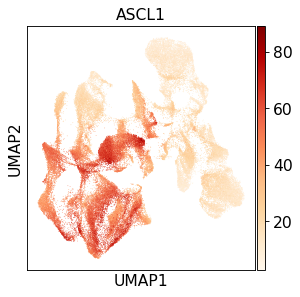

In [104]:
# Neural
sc.pl.umap(gene_adata, color = ['ASCL1'], ncols = 3, color_map = 'OrRd')

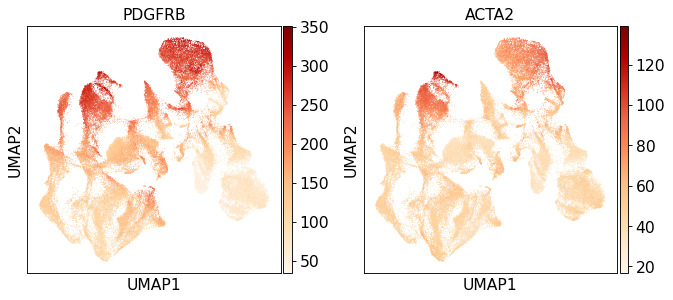

In [105]:
# Perivascular
sc.pl.umap(gene_adata, color = ["PDGFRB", 'ACTA2'], ncols = 3, color_map = 'OrRd')

In [106]:
gene_adata.write(outdir + experiment_prefix + "_ATAC.geneScores.h5ad")

### CICERO CCANs

In [19]:
p_mat_transpose = p_mat.T 

In [20]:
ccans = pd.read_csv(outdir + experiment_prefix + "_ccans_annotate_prova.csv", index_col = 0)
ccans = pd.DataFrame(ccans)
ccans.head()

Peak  CCAN           peaks_formatted  peak_width  exon  \
1    chr1:10012734-10013195   554    chr1-10012734-10013195         462     0   
2      chr1:1001658-1002084   556      chr1-1001658-1002084         427     0   
3    chr1:10031482-10031813   554    chr1-10031482-10031813         332     0   
4  chr1:100354899-100355208     2  chr1-100354899-100355208         310     0   
5  chr1:100357612-100358485     2  chr1-100357612-100358485         874     0   

           gene_id  gene gene_name annotation  promoter  tss_distance  \
1  ENSG00000162444     1      RBP7     intron         0         15517   
2  ENSG00000187608     1     ISG15   promoter         1           512   
3  ENSG00000130939     0     UBE4B   promoter         1          1018   
4  ENSG00000079335     1    CDC14A     intron         0          2298   
5  ENSG00000079335     1    CDC14A     intron         0          5011   

   ENCODE_blacklist  
1                 0  
2                 0  
3                 0  
4                 0  
5                 0

In [21]:
adata.var.shape

(159132, 15)

In [22]:
peaksinCCANs = list(ccans['Peak'])

In [23]:
cistopic = pd.DataFrame(p_mat_transpose, index=adata.obs_names, columns=adata.var_names)
cistopic.head()

chr1:816748-817444  chr1:825667-826059  \
01-AAACAGCCACTAGCGT-1            0.000004            0.000003   
01-AAACCGGCAACCCTCC-1            0.000003            0.000004   
01-AAACCGGCAAGTAAGC-1            0.000005            0.000003   
01-AAACGGATCCGCCAAA-1            0.000002            0.000003   
01-AAACGTACAGGTTATT-1            0.000002            0.000003   

                       chr1:826598-827811  chr1:868830-869161  \
01-AAACAGCCACTAGCGT-1            0.000033        2.661258e-06   
01-AAACCGGCAACCCTCC-1            0.000025        7.310138e-07   
01-AAACCGGCAAGTAAGC-1            0.000028        2.241345e-06   
01-AAACGGATCCGCCAAA-1            0.000028        1.378051e-06   
01-AAACGTACAGGTTATT-1            0.000022        8.338780e-07   

                       chr1:869380-870259  chr1:875055-875919  \
01-AAACAGCCACTAGCGT-1            0.000015            0.000004   
01-AAACCGGCAACCCTCC-1            0.000010            0.000002   
01-AAACCGGCAAGTAAGC-1            0.000016            0.000002   
01-AAACGGATCCGCCAAA-1            0.000012            0.000002   
01-AAACGTACAGGTTATT-1            0.000012            0.000005   

                       chr1:876133-877358  chr1:901193-901648  \
01-AAACAGCCACTAGCGT-1            0.000005            0.000004   
01-AAACCGGCAACCCTCC-1            0.000005            0.000003   
01-AAACCGGCAAGTAAGC-1            0.000005            0.000005   
01-AAACGGATCCGCCAAA-1            0.000005            0.000001   
01-AAACGTACAGGTTATT-1            0.000008            0.000002   

                       chr1:916349-917433  chr1:920446-921385  ...  \
01-AAACAGCCACTAGCGT-1            0.000014            0.000021  ...   
01-AAACCGGCAACCCTCC-1            0.000018            0.000021  ...   
01-AAACCGGCAAGTAAGC-1            0.000014            0.000018  ...   
01-AAACGGATCCGCCAAA-1            0.000011            0.000017  ...   
01-AAACGTACAGGTTATT-1            0.000014            0.000022  ...   

                       chrY:18923086-18924231  chrY:18992531-18993253  \
01-AAACAGCCACTAGCGT-1            1.161814e-06                0.000002   
01-AAACCGGCAACCCTCC-1            1.128924e-06                0.000001   
01-AAACCGGCAAGTAAGC-1            4.425674e-07                0.000002   
01-AAACGGATCCGCCAAA-1            1.214077e-06                0.000002   
01-AAACGTACAGGTTATT-1            1.000395e-06                0.000002   

                       chrY:19002842-19003860  chrY:19043094-19043880  \
01-AAACAGCCACTAGCGT-1                0.000003            1.691756e-06   
01-AAACCGGCAACCCTCC-1                0.000006            7.216314e-07   
01-AAACCGGCAAGTAAGC-1                0.000002            1.507627e-06   
01-AAACGGATCCGCCAAA-1                0.000005            1.100388e-06   
01-AAACGTACAGGTTATT-1                0.000006            8.064780e-07   

                       chrY:19066186-19067095  chrY:19566682-19568146  \
01-AAACAGCCACTAGCGT-1                0.000002                0.000034   
01-AAACCGGCAACCCTCC-1                0.000002                0.000016   
01-AAACCGGCAAGTAAGC-1                0.000002                0.000025   
01-AAACGGATCCGCCAAA-1                0.000001                0.000022   
01-AAACGTACAGGTTATT-1                0.000002                0.000021   

                       chrY:19572585-19573139  chrY:19578132-19578969  \
01-AAACAGCCACTAGCGT-1                0.000002            1.026254e-06   
01-AAACCGGCAACCCTCC-1                0.000004            2.420142e-06   
01-AAACCGGCAAGTAAGC-1                0.000002            8.904463e-07   
01-AAACGGATCCGCCAAA-1                0.000004            2.043074e-06   
01-AAACGTACAGGTTATT-1                0.000004            2.442115e-06   

                       chrY:20559718-20560765  chrY:22727882-22729063  
01-AAACAGCCACTAGCGT-1            1.796241e-06                0.000005  
01-AAACCGGCAACCCTCC-1            8.802877e-07                0.000002  
01-AAACCGGCAAGTAAGC-1            1.714299e-06                0.000

In [24]:
cells_peaksinCCANs = cistopic.loc[:, peaksinCCANs]
cells_peaksinCCANs.shape

(77780, 44045)

In [25]:
annots = sc.read(outdir + experiment_prefix + "_harmony_ATACwCisTopic.h5ad")
#annots = annots[[i in ['CoelEpi_LHX9', 'early_supporting', 
#                                        'preGC_I', 'OSE', 'preGC_IIa', 'preGC_IIb', 'granulosa'] for i in annots.obs['cell_type']]]
print(annots.shape)
barcodes = list(annots.obs_names)
cells_peaksinCCANs = cells_peaksinCCANs.loc[barcodes, :]

(74592, 159132)


In [26]:
cells_peaksinCCANs.head()

chr1:10012734-10013195  chr1:1001658-1002084  \
01-AAACAGCCACTAGCGT-1                0.000003              0.000026   
01-AAACCGGCAACCCTCC-1                0.000002              0.000015   
01-AAACCGGCAAGTAAGC-1                0.000004              0.000020   
01-AAACGGATCCGCCAAA-1                0.000002              0.000015   
01-AAACGTACAGGTTATT-1                0.000002              0.000019   

                       chr1:10031482-10031813  chr1:100354899-100355208  \
01-AAACAGCCACTAGCGT-1                0.000007                  0.000014   
01-AAACCGGCAACCCTCC-1                0.000004                  0.000019   
01-AAACCGGCAAGTAAGC-1                0.000010                  0.000017   
01-AAACGGATCCGCCAAA-1                0.000006                  0.000022   
01-AAACGTACAGGTTATT-1                0.000005                  0.000019   

                       chr1:100357612-100358485  chr1:100360642-100361248  \
01-AAACAGCCACTAGCGT-1                  0.000014                  0.000014   
01-AAACCGGCAACCCTCC-1                  0.000017                  0.000020   
01-AAACCGGCAAGTAAGC-1                  0.000016                  0.000016   
01-AAACGGATCCGCCAAA-1                  0.000018                  0.000013   
01-AAACGTACAGGTTATT-1                  0.000011                  0.000012   

                       chr1:100364322-100365277  chr1:10043548-10044185  \
01-AAACAGCCACTAGCGT-1                  0.000012                0.000009   
01-AAACCGGCAACCCTCC-1                  0.000014                0.000006   
01-AAACCGGCAAGTAAGC-1                  0.000011                0.000010   
01-AAACGGATCCGCCAAA-1                  0.000015                0.000003   
01-AAACGTACAGGTTATT-1                  0.000012                0.000002   

                       chr1:1004477-1005711  chr1:100469196-100469956  ...  \
01-AAACAGCCACTAGCGT-1              0.000035                  0.000008  ...   
01-AAACCGGCAACCCTCC-1              0.000035                  0.000004  ...   
01-AAACCGGCAAGTAAGC-1              0.000029                  0.000010  ...   
01-AAACGGATCCGCCAAA-1              0.000018                  0.000016  ...   
01-AAACGTACAGGTTATT-1              0.000034                  0.000004  ...   

                       chrY:13442539-13443616  chrY:15422632-15423725  \
01-AAACAGCCACTAGCGT-1                0.000004                0.000004   
01-AAACCGGCAACCCTCC-1                0.000001                0.000006   
01-AAACCGGCAAGTAAGC-1                0.000004                0.000003   
01-AAACGGATCCGCCAAA-1                0.000002                0.000006   
01-AAACGTACAGGTTATT-1                0.000001                0.000006   

                       chrY:15423946-15425317  chrY:15455485-15456728  \
01-AAACAGCCACTAGCGT-1                0.000006                0.000012   
01-AAACCGGCAACCCTCC-1                0.000006                0.000005   
01-AAACCGGCAAGTAAGC-1                0.000004                0.000010   
01-AAACGGATCCGCCAAA-1                0.000006                0.000008   
01-AAACGTACAGGTTATT-1                0.000006                0.000006   

                       chrY:19566682-19568146  chrY:19572585-19573139  \
01-AAACAGCCACTAGCGT-1                0.000034                0.000002   
01-AAACCGGCAACCCTCC-1                0.000016                0.000004   
01-AAACCGGCAAGTAAGC-1                0.000025                0.000002   
01-AAACGGATCCGCCAAA-1                0.000022                0.000004   
01-AAACGTACAGGTTATT-1                0.000021                0.000004   

                       chrY:19578132-19578969  chrY:7085511-7086104  \
01-AAACAGCCACTAGCGT-1            1.026254e-06              0.000004   
01-AAACCGGCAACCCTCC-1            2.420142e-06              0.000002   
01-AAACCGGCAAGTAAGC-1            8.904463e-07              0.000004   
01-AAACGGATCCGCCAAA-1            2.043074e-06              0.000003   
01-AAACGTACAGGTTATT-1            2.442115e-06              0.000003   

                  

In [27]:
# Mapping of cells to cell types 
annots.obs['barcode'] = annots.obs_names
cells_celltypes = annots.obs[['barcode', 'cell_type', 'sex']]
cells_celltypes.head()

barcode         cell_type     sex
01-AAACAGCCACTAGCGT-1  01-AAACAGCCACTAGCGT-1           Sertoli  female
01-AAACCGGCAACCCTCC-1  01-AAACCGGCAACCCTCC-1  early_supporting  female
01-AAACCGGCAAGTAAGC-1  01-AAACCGGCAAGTAAGC-1  early_supporting  female
01-AAACGGATCCGCCAAA-1  01-AAACGGATCCGCCAAA-1               OSE  female
01-AAACGTACAGGTTATT-1  01-AAACGTACAGGTTATT-1  early_supporting  female

In [28]:
cells_celltypes['cell_type'].value_counts(dropna = False)

Sertoli             14285
Ti                   8828
preGC_IIa            8676
preGC_I              6677
early_supporting     6506
preGC_IIb            5733
Oi                   5657
OSE                  5007
Gi                   4237
FetalLeydig          2328
sPAX8                2201
CoelEpi_GATA2        1711
CoelEpi_LHX9         1569
granulosa            1177
Name: cell_type, dtype: int64

In [43]:
cells_mapping = cells_celltypes.groupby('cell_type').groups
# Mean by rows 
for key in cells_mapping: 
    print(key)
    cells_peaksinCCANs.loc[key] = cells_peaksinCCANs.loc[cells_mapping[key]].mean(axis = 0)

CoelEpi_LHX9
early_supporting
preGC_I
OSE
preGC_IIa
preGC_IIb
granulosa


In [44]:
cells_celltypes['cell_type'].value_counts(dropna = False)

preGC_IIa           8676
preGC_I             6677
early_supporting    6506
preGC_IIb           5733
OSE                 5007
CoelEpi_LHX9        1569
granulosa           1177
Name: cell_type, dtype: int64

In [45]:
rows_celltypes = list(np.unique(cells_celltypes['cell_type']))
print(rows_celltypes)
# Select only aggregated rows
cells_peaksinCCANs = cells_peaksinCCANs.loc[rows_celltypes, ]

['CoelEpi_LHX9', 'OSE', 'early_supporting', 'granulosa', 'preGC_I', 'preGC_IIa', 'preGC_IIb']


In [29]:
# Mapping of peaks to CCANs 
ccans = ccans.set_index('Peak')
peaks_ccans = ccans[['CCAN', 'peak_width']]
peaks_mapping = peaks_ccans.groupby('CCAN').groups

In [30]:
ccans.head()

CCAN           peaks_formatted  peak_width  exon  \
Peak                                                                         
chr1:10012734-10013195     554    chr1-10012734-10013195         462     0   
chr1:1001658-1002084       556      chr1-1001658-1002084         427     0   
chr1:10031482-10031813     554    chr1-10031482-10031813         332     0   
chr1:100354899-100355208     2  chr1-100354899-100355208         310     0   
chr1:100357612-100358485     2  chr1-100357612-100358485         874     0   

                                  gene_id  gene gene_name annotation  \
Peak                                                                   
chr1:10012734-10013195    ENSG00000162444     1      RBP7     intron   
chr1:1001658-1002084      ENSG00000187608     1     ISG15   promoter   
chr1:10031482-10031813    ENSG00000130939     0     UBE4B   promoter   
chr1:100354899-100355208  ENSG00000079335     1    CDC14A     intron   
chr1:100357612-100358485  ENSG00000079335     1    CDC14A     intron   

                          promoter  tss_distance  ENCODE_blacklist  
Peak                                                                
chr1:10012734-10013195           0         15517                 0  
chr1:1001658-1002084             1           512                 0  
chr1:10031482-10031813           1          1018                 0  
chr1:100354899-100355208         0          2298                 0  
chr1:100357612-100358485         0          5011                 0

In [31]:
cells_peaksinCCANs.head()

chr1:10012734-10013195  chr1:1001658-1002084  \
01-AAACAGCCACTAGCGT-1                0.000003              0.000026   
01-AAACCGGCAACCCTCC-1                0.000002              0.000015   
01-AAACCGGCAAGTAAGC-1                0.000004              0.000020   
01-AAACGGATCCGCCAAA-1                0.000002              0.000015   
01-AAACGTACAGGTTATT-1                0.000002              0.000019   

                       chr1:10031482-10031813  chr1:100354899-100355208  \
01-AAACAGCCACTAGCGT-1                0.000007                  0.000014   
01-AAACCGGCAACCCTCC-1                0.000004                  0.000019   
01-AAACCGGCAAGTAAGC-1                0.000010                  0.000017   
01-AAACGGATCCGCCAAA-1                0.000006                  0.000022   
01-AAACGTACAGGTTATT-1                0.000005                  0.000019   

                       chr1:100357612-100358485  chr1:100360642-100361248  \
01-AAACAGCCACTAGCGT-1                  0.000014                  0.000014   
01-AAACCGGCAACCCTCC-1                  0.000017                  0.000020   
01-AAACCGGCAAGTAAGC-1                  0.000016                  0.000016   
01-AAACGGATCCGCCAAA-1                  0.000018                  0.000013   
01-AAACGTACAGGTTATT-1                  0.000011                  0.000012   

                       chr1:100364322-100365277  chr1:10043548-10044185  \
01-AAACAGCCACTAGCGT-1                  0.000012                0.000009   
01-AAACCGGCAACCCTCC-1                  0.000014                0.000006   
01-AAACCGGCAAGTAAGC-1                  0.000011                0.000010   
01-AAACGGATCCGCCAAA-1                  0.000015                0.000003   
01-AAACGTACAGGTTATT-1                  0.000012                0.000002   

                       chr1:1004477-1005711  chr1:100469196-100469956  ...  \
01-AAACAGCCACTAGCGT-1              0.000035                  0.000008  ...   
01-AAACCGGCAACCCTCC-1              0.000035                  0.000004  ...   
01-AAACCGGCAAGTAAGC-1              0.000029                  0.000010  ...   
01-AAACGGATCCGCCAAA-1              0.000018                  0.000016  ...   
01-AAACGTACAGGTTATT-1              0.000034                  0.000004  ...   

                       chrY:13442539-13443616  chrY:15422632-15423725  \
01-AAACAGCCACTAGCGT-1                0.000004                0.000004   
01-AAACCGGCAACCCTCC-1                0.000001                0.000006   
01-AAACCGGCAAGTAAGC-1                0.000004                0.000003   
01-AAACGGATCCGCCAAA-1                0.000002                0.000006   
01-AAACGTACAGGTTATT-1                0.000001                0.000006   

                       chrY:15423946-15425317  chrY:15455485-15456728  \
01-AAACAGCCACTAGCGT-1                0.000006                0.000012   
01-AAACCGGCAACCCTCC-1                0.000006                0.000005   
01-AAACCGGCAAGTAAGC-1                0.000004                0.000010   
01-AAACGGATCCGCCAAA-1                0.000006                0.000008   
01-AAACGTACAGGTTATT-1                0.000006                0.000006   

                       chrY:19566682-19568146  chrY:19572585-19573139  \
01-AAACAGCCACTAGCGT-1                0.000034                0.000002   
01-AAACCGGCAACCCTCC-1                0.000016                0.000004   
01-AAACCGGCAAGTAAGC-1                0.000025                0.000002   
01-AAACGGATCCGCCAAA-1                0.000022                0.000004   
01-AAACGTACAGGTTATT-1                0.000021                0.000004   

                       chrY:19578132-19578969  chrY:7085511-7086104  \
01-AAACAGCCACTAGCGT-1            1.026254e-06              0.000004   
01-AAACCGGCAACCCTCC-1            2.420142e-06              0.000002   
01-AAACCGGCAAGTAAGC-1            8.904463e-07              0.000004   
01-AAACGGATCCGCCAAA-1            2.043074e-06              0.000003   
01-AAACGTACAGGTTATT-1            2.442115e-06              0.000003   

                  

In [ ]:
# Mean by columns 
for key in peaks_mapping: 
    cells_peaksinCCANs[key] = cells_peaksinCCANs[peaks_mapping[key]].mean(axis = 1)

In [55]:
cols_ccans = list(np.unique(peaks_ccans['CCAN']))
# Select only aggregated rows and columns 
celltype_CCANs = cells_peaksinCCANs.loc[:, cols_ccans]
celltype_CCANs = celltype_CCANs.loc[(celltype_CCANs.sum(axis=1) != 0), (celltype_CCANs.sum(axis=0) != 0)]

In [56]:
# Normalize by column (CCAN)
from scipy.stats import zscore
celltype_CCANs_zscore = celltype_CCANs.apply(zscore)

In [57]:
celltype_CCANs_zscore.to_csv(outdir + experiment_prefix + "_zscore_ccans_supporting_female.csv")

In [58]:
celltype_CCANs_zscore.index

Index(['CoelEpi_LHX9', 'OSE', 'early_supporting', 'granulosa', 'preGC_I',
       'preGC_IIa', 'preGC_IIb'],
      dtype='object')

In [59]:
celltype_CCANs_zscore = celltype_CCANs_zscore.reindex(['CoelEpi_LHX9', 'early_supporting', 
                                        'preGC_I', 'OSE', 'preGC_IIa', 'preGC_IIb', 'granulosa'])

In [60]:
import matplotlib
divnorm = matplotlib.colors.DivergingNorm(vmin=celltype_CCANs_zscore.values.min(), vcenter=0, vmax=celltype_CCANs_zscore.values.max())

<ipython-input-60-bf861d7723b7>:2: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  divnorm = matplotlib.colors.DivergingNorm(vmin=celltype_CCANs_zscore.values.min(), vcenter=0, vmax=celltype_CCANs_zscore.values.max())


In [61]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

/opt/conda/envs/atac_env/lib/python3.8/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


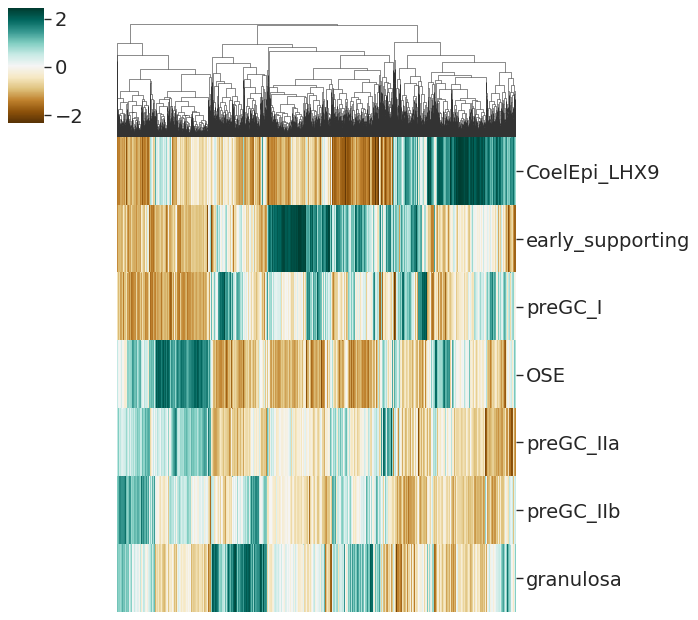

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.6)
heatmap = sns.clustermap(celltype_CCANs_zscore, row_cluster=False, annot=False, xticklabels = False, yticklabels = "auto",  figsize=(9, 8),
                         cmap = "BrBG")
heatmap.savefig("/home/jovyan/MULTIOME_july2021/figures_somatic/heatmap_female_supporting_ccans_green.pdf")

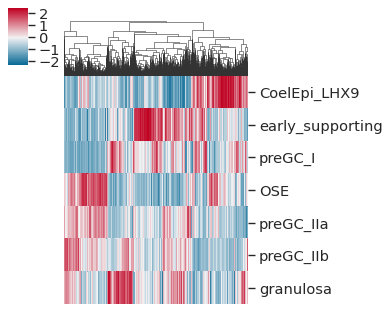

In [67]:
my_cmap = sns.diverging_palette(240, 10, n=10, s = 100, l = 40, as_cmap=True)
sns.set(font_scale=1.2)

heatmap = sns.clustermap(celltype_CCANs_zscore, row_cluster=False, annot=False, xticklabels = False, yticklabels = "auto",  figsize=(5, 4),
                         cmap = my_cmap, norm = divnorm)
heatmap.savefig("/home/jovyan/MULTIOME_july2021/figures_somatic/heatmap_female_supporting_ccans_red.pdf")


In [10]:
celltype_CCANs_zscore = pd.read_csv(outdir + experiment_prefix + "_zscore_ccans.csv", index_col = 0)

In [13]:
celltype_CCANs_zscore_supporting = celltype_CCANs_zscore.loc[['CoelEpi_LHX9', 'early_supporting', 
                                        'preGC_I', 'OSE', 'preGC_IIa', 'preGC_IIb', 'granulosa']]

In [15]:
celltype_CCANs_zscore_supporting = celltype_CCANs_zscore_supporting.reindex(['CoelEpi_LHX9', 'early_supporting', 
                                        'preGC_I', 'OSE', 'preGC_IIa', 'preGC_IIb', 'granulosa'])

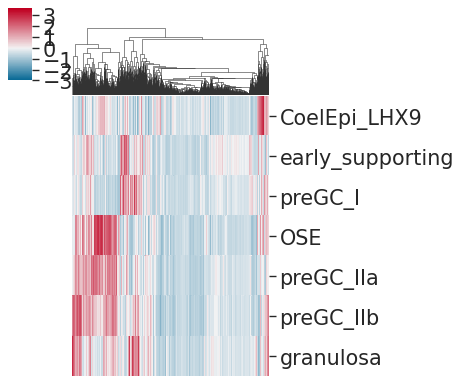

In [21]:
import seaborn as sns
my_cmap = sns.diverging_palette(240, 10, n=10, s = 100, l = 40, as_cmap=True)
sns.set(font_scale=1.7)

heatmap = sns.clustermap(celltype_CCANs_zscore_supporting, row_cluster=False, annot=False, xticklabels = False, yticklabels = "auto",  figsize=(6, 5),
                         cmap = my_cmap, norm = divnorm)
heatmap.savefig("/home/jovyan/MULTIOME_july2021/figures_somatic/heatmap_female_supporting_ccans_red.pdf")